In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

# Data Download 

In [ ]:
# Upload Kaggle credentials to runtime prior to running this block
with open('./kaggle.json', 'r') as f:
    data = json.load(f)
    os.environ['KAGGLE_USERNAME'] = data['username']
    os.environ['KAGGLE_KEY'] = data['key']

In [ ]:
data_dir = "/content/drive/MyDrive/assets/data/Fer2013"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
os.chdir(data_dir)
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 1.02MB/s]
100% 92.0M/92.0M [00:00<00:00, 101MB/s] 

 88% 17.0M/19.3M [00:00<00:00, 71.3MB/s]
100% 19.3M/19.3M [00:00<00:00, 74.3MB/s]
 91% 88.0M/96.6M [00:01<00:00, 97.4MB/s]
100% 96.6M/96.6M [00:01<00:00, 84.9MB/s]
 92% 71.0M/77.3M [00:00<00:00, 74.8MB/s]
100% 77.3M/77.3M [00:01<00:00, 78.9MB/s]


In [ ]:
!tar -xvf fer2013.tar.gz
!unzip test.csv.zip
!unzip train.csv.zip
!unzip icml_face_data.csv.zip

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  icml_face_data.csv.zip
  inflating: icml_face_data.csv      


In [ ]:
!rm fer2013.tar.gz test.csv.zip train.csv.zip icml_face_data.csv.zip

In [ ]:
!mv fer2013/fer2013.csv ./

# Dataset

In [6]:
data_dir = "/content/drive/MyDrive/assets/data/Fer2013"
data = pd.read_csv(data_dir + '/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Filter dataset to 3 classes = [Happy, Sad, Neutral]

In [7]:
# emotions = {0: 'Angry',
#             1: 'Disgust',
#             2: 'Fear',
#             3: 'Happy',
#             4: 'Sad',
#             5: 'Surprise',
#             6: 'Neutral'}

# emotions_filtered = {3:'Happy',
#                      4:'Sad',
#                      6:'Neutral'}


convert_emotions = {3: 0,
                    4: 1,
                    6: 2}

selected_classes = list(convert_emotions.keys())

selected_emotions = {0: 'Happy',
                     1: 'Sad',
                     2: 'Neutral'}

In [8]:
data_filtered = pd.DataFrame(columns=['emotion', ' Usage', ' pixels'])
for i, row in enumerate(data.index):
    if data.loc[row, 'emotion'] in selected_classes:
        data_filtered = data_filtered.append(data.iloc[i])
data_filtered

,emotion,Usage,pixels
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
...,...,...,...
35877,6,PrivateTest,139 143 145 154 159 168 176 181 190 191 195 19...
35878,3,PrivateTest,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...


In [12]:
data_filtered.reset_index(inplace=True)
data_filtered.drop(['index'], axis=1, inplace=True)
data_filtered

,emotion,Usage,pixels
0,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
1,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
2,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
3,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
4,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
...,...,...,...
21259,6,PrivateTest,139 143 145 154 159 168 176 181 190 191 195 19...
21260,3,PrivateTest,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
21261,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
21262,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...


In [14]:
import copy

new_data = copy.deepcopy(data_filtered)
for i in range(len(new_data)):
    new_data.emotion[i] = convert_emotions[new_data.emotion[i]]

new_data

,emotion,Usage,pixels
0,1,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
1,2,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
2,1,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
3,0,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
4,0,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
...,...,...,...
21259,2,PrivateTest,139 143 145 154 159 168 176 181 190 191 195 19...
21260,0,PrivateTest,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
21261,2,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
21262,0,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...


## Data Preparation

In [15]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(selected_emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    num_classes = len(new_data['emotion'].value_counts())
    fig, axs = plt.subplots(1, num_classes, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(num_classes):
        idx = new_data[new_data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title([train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = selected_emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(selected_emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = selected_emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(selected_emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(selected_emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [16]:
new_data[' Usage'].value_counts()

Training       17010
PublicTest      2155
PrivateTest     2099
Name:  Usage, dtype: int64

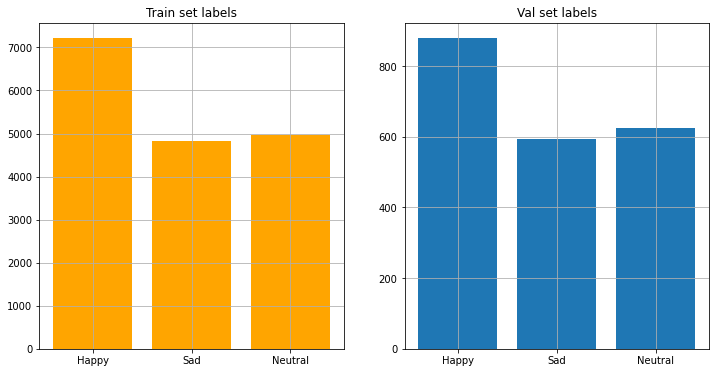

In [23]:
plot_compare_distributions(train_labels, val_labels, title1='Train set labels', title2='Val set labels')

In [17]:
train_image_array, train_image_label = prepare_data(new_data[new_data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(new_data[new_data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(new_data[new_data[' Usage']=='PublicTest'])

In [18]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [19]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

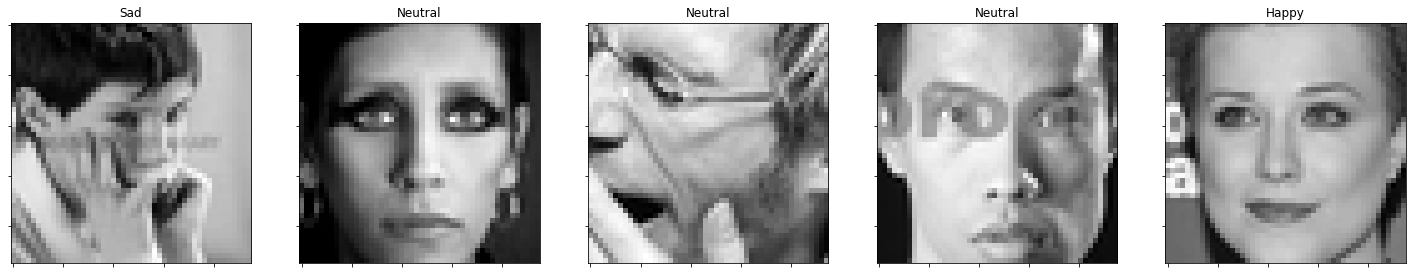

In [21]:
plot_examples()

In [24]:
class_weight = dict(zip(range(0, 3), (((new_data[new_data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(new_data[new_data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.42416225749559083, 1: 0.2839506172839506, 2: 0.29188712522045857}

# Define Model

In [60]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [61]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [62]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30
BATCH_SIZE = 64

ckpt = "/content/drive/MyDrive/facial-expression-recognition-using-cnn/checkpoints/best_model.hdf5"
callbacks = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=30,
                    batch_size=64,
                    callbacks=[callbacks])

Epoch 1/30
266/266 [==============================] - 2s 6ms/step - loss: 0.3495 - accuracy: 0.4261 - val_loss: 1.0217 - val_accuracy: 0.4693
Epoch 2/30
266/266 [==============================] - 2s 6ms/step - loss: 0.3153 - accuracy: 0.5072 - val_loss: 0.9108 - val_accuracy: 0.5784
Epoch 3/30
266/266 [==============================] - 2s 6ms/step - loss: 0.2922 - accuracy: 0.5737 - val_loss: 0.8783 - val_accuracy: 0.5841
Epoch 4/30
266/266 [==============================] - 1s 5ms/step - loss: 0.2814 - accuracy: 0.5937 - val_loss: 0.8432 - val_accuracy: 0.6089
Epoch 5/30
266/266 [==============================] - 1s 5ms/step - loss: 0.2725 - accuracy: 0.6096 - val_loss: 0.8102 - val_accuracy: 0.6365
Epoch 6/30
266/266 [==============================] - 1s 6ms/step - loss: 0.2643 - accuracy: 0.6263 - val_loss: 0.8110 - val_accuracy: 0.6251
Epoch 7/30
266/266 [==============================] - 1s 6ms/step - loss: 0.2568 - accuracy: 0.6345 - val_loss: 0.7785 - val_accuracy: 0.6508
Epoch 

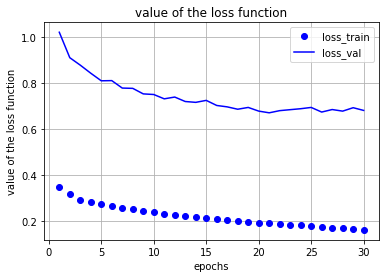

In [64]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [65]:
model.save(ckpt)

In [66]:
model.load_weights(ckpt)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc)

68/68 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.6942
Test Accuracy: 0.6941995620727539


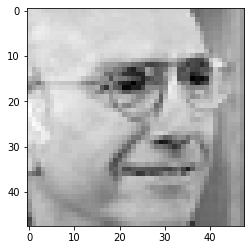

Output:  [0.71387744 0.11966923 0.16645333]
Model predict:  0
True answer:  [1. 0. 0.]


In [94]:
import random
import matplotlib.pyplot as plt

# Get random image in test dataset
rand = random.choice(range(len(test_images)))

image = test_images[rand]

plt.imshow(image.reshape(48,48), cmap=plt.get_cmap('gray'))
plt.show()

# Feature scaling
image = np.expand_dims(image,axis=0)

# Prediction
predict = model.predict(image)[0]
print("Output: " ,predict)
print("Model predict: ", np.argmax(predict))
print("True answer: ", test_labels[rand])